# import necessary library

In [1]:
# for garbage collection
import gc

# for warnings
import warnings
warnings.filterwarnings("ignore")

# utility libraries
import os
import copy
import tqdm
import numpy as np 
import pandas as pd 
import cv2, random, time, shutil, csv
import tensorflow as tf 
import math
import time
from util import *

# keras libraries
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Dense, GlobalAveragePooling2D, Lambda, Dropout, InputLayer, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K

In [2]:
# checking if GPU is being used for training
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
    print("GPU is not detected")

Default GPU Device:/device:GPU:0


# prepare of data set


In [3]:
# loading labels from csv file
data_dir = os.path.join(os.getcwd(), 'Datasets')
data_df = pd.read_csv(os.path.join(data_dir, 'labels.csv'))
breeds = sorted(data_df.breed.unique())

print(f"Shape\t\t: {data_df.shape}")
print(f"Unique labels\t: {len(breeds)}")

Shape		: (10222, 2)
Unique labels	: 120


In [4]:
# hyperparameters
img_size = 299
batch_size=128
epochs=80

In [5]:
# load images data
def loadData():
    images_list = sorted(os.listdir(os.path.join(data_dir, 'train')))
    X = []
    Y = []
    for image in tqdm.tqdm(images_list):
        # find matching label
        breed = data_df[data_df['id'] == image[:-4]].iloc[0,1]
        breed_index = int(breeds.index(breed)) 

        # reading image data
        image_path = os.path.join(data_dir, 'train', image)
        res_image = load_img(image_path, target_size=(img_size, img_size))
        res_image = np.asarray(res_image)
        X.append(res_image)
        Y.append(breed_index)
    return X, Y

In [6]:
saving_path = os.path.join(data_dir, f'data_resized{img_size}x{img_size}.h5')


t = time.time()
if (os.path.isfile(saving_path)):
    X, Y = load_h5_data(saving_path)
else:
    X, Y = loadData()
    generate_h5_data(X, Y, saving_path)
print(f'Time taken: {time.time()-t}')


Time taken: 3.2278592586517334


In [7]:
# Converting to arrays
print(len(X), len(Y))
assert(len(X)==len(Y))
Xarr = np.array(X)
Yarr = np.array(Y).reshape(-1,1)

del(X)
print(Xarr.shape, Yarr.shape)
gc.collect()

10222 10222
(10222, 299, 299, 3) (10222, 1)


110

In [8]:
# print out shape, dtype and data size
nparray_info("\nXarr", Xarr)
nparray_info("\nYarr", Yarr)


Xarr
-  shape	 (10222, 299, 299, 3)
-  dtype	 uint8
- nbytes	 2741571066 (2.55 GB)

Yarr
-  shape	 (10222, 1)
-  dtype	 int32
- nbytes	 40888 (39.93 KB)


In [9]:
# converting labels to one hot
Yarr_hot = to_categorical(Y)
print(Xarr.shape, Yarr_hot.shape)

(10222, 299, 299, 3) (10222, 120)


# Feature Extraction

In [10]:
# FEATURE EXTRACTION OF TRAINING ARRAYS
AUTO = tf.data.experimental.AUTOTUNE
def get_features(model_name, data_preprocessor, data):
    '''
    1- Create a feature extractor to extract features from the data.
    2- Returns the extracted features and the feature extractor.
    '''
    dataset = tf.data.Dataset.from_tensor_slices(data)


    def preprocess(x):
        x = tf.image.random_flip_left_right(x)
        x = tf.image.random_brightness(x, 0.5)
        return x

    ds = dataset.map(preprocess, num_parallel_calls=AUTO).batch(64)

    input_size = data.shape[1:]
    #Prepare pipeline.
    input_layer = Input(input_size)
    preprocessor = Lambda(data_preprocessor)(input_layer)

    base_model = model_name(weights='imagenet', include_top=False,
                                input_shape=input_size)(preprocessor)

    avg = GlobalAveragePooling2D()(base_model)
    feature_extractor = Model(inputs = input_layer, outputs = avg)


    #Extract feature.
    feature_maps = feature_extractor.predict(ds, verbose=1)
    nparray_info("Feature maps", feature_maps)
    
    # deleting variables
    del(feature_extractor, base_model, preprocessor, dataset)
    gc.collect()
    return feature_maps

In [11]:
# FEATURE EXTRACTION OF VALIDAION AND TESTING ARRAYS
def get_valfeatures(model_name, data_preprocessor, data):
    '''
    Same as above except not image augmentations applied.
    Used for feature extraction of validation and testing.
    '''

    dataset = tf.data.Dataset.from_tensor_slices(data)

    ds = dataset.batch(64)

    input_size = data.shape[1:]
    #Prepare pipeline.
    input_layer = Input(input_size)
    preprocessor = Lambda(data_preprocessor)(input_layer)

    base_model = model_name(weights='imagenet', include_top=False, input_shape=input_size)(preprocessor)

    avg = GlobalAveragePooling2D()(base_model)
    feature_extractor = Model(inputs = input_layer, outputs = avg)
    #Extract feature.
    feature_maps = feature_extractor.predict(ds, verbose=1)
    nparray_info("Feature maps", feature_maps)
    return feature_maps

In [12]:
# generate feature dictionary 
def generate_model_features(feat_func, model_names, models, preprocs, array):
    print(f"Beggining extraction with {feat_func.__name__}\n")
    feats_dict = {}

    for i in range(len(models)):
        print(f"\nStarting feature extraction with {models[i].__name__} using {preprocs[i].__name__}\n")
        # applying the above function and storing in list
        feats_dict[model_names[i]] = feat_func(models[i], preprocs[i], array)
        
    # memory saving
    del(array)
    gc.collect()
    return feats_dict

In [13]:
# RETURNING CONCATENATED FEATURES
def get_concat_features(model_names, feats_dict):
    feats_list = []
    
    for name in model_names:
        print(f"collect features for {name}...")
        feats_list.append( feats_dict[name] )

    # features concatenating
    final_feats = np.concatenate(feats_list, axis=-1)
    # memory saving
    del(feats_list)
    gc.collect()
    return final_feats

In [14]:
# DEFINING models and preprocessors imports
from tensorflow.keras.applications.xception import Xception, preprocess_input
xception_preprocessor = preprocess_input
from tensorflow.keras.applications.densenet import DenseNet169, preprocess_input
densenet_preprocessor = preprocess_input
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
inc_resnet_preprocessor = preprocess_input
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input 
mobilenet_preprocessor = preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
inception_preprocessor = preprocess_input
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input
restnet_preprocessor = preprocess_input


# collecting top 6 models' features for evaluation later
model_names = ["Xception", "DenseNet169", "InceptionResNetV2", "MobileNet", "InceptionV3", "RestNet50"]
models = [Xception, DenseNet169, InceptionResNetV2, MobileNet, InceptionV3, ResNet50 ]
preprocs = [xception_preprocessor, densenet_preprocessor, inc_resnet_preprocessor, 
            mobilenet_preprocessor, inception_preprocessor, restnet_preprocessor]

In [15]:
# Perform feature extraction and save as h5 file
saving_path = os.path.join(data_dir, f'features.h5')

t = time.time()
# feats_dict = {}
if (os.path.isfile(saving_path)):
    feats_dict = load_features_data(saving_path)
else:
    feats_dict = generate_model_features(get_features, model_names, models, preprocs, Xarr)
    generate_features_data(feats_dict, saving_path)
gc.collect()
print(f'Time taken: {time.time()-t}')

loading features for DenseNet169...
loading features for InceptionResNetV2...
loading features for InceptionV3...
loading features for MobileNet...
loading features for RestNet50...
loading features for Xception...
features loaded
Time taken: 0.5029191970825195


In [21]:
for name in feats_dict:
#     nparray_info(name, feats_dict[name])
    print(name)

DenseNet169
InceptionResNetV2
InceptionV3
MobileNet
RestNet50
Xception


In [22]:
train_models = [model_names[i] for i in range(3)]    # can replace range to [0,1,2]
final_train_features = get_concat_features(train_models, feats_dict)

gc.collect()
nparray_info("Final feature maps", final_train_features)

collect features for Xception...
collect features for DenseNet169...
collect features for InceptionResNetV2...
Final feature maps
-  shape	 (10222, 5248)
-  dtype	 float32
- nbytes	 214580224 (204.64 MB)


In [23]:
from tensorflow.keras.callbacks import EarlyStopping
EarlyStop_callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=0)

my_callback=[EarlyStop_callback]


Starting fold 1

Training...
Evaluating model ...
256/256 [==============================] - 0s 2ms/step - loss: 0.0502 - accuracy: 0.9884


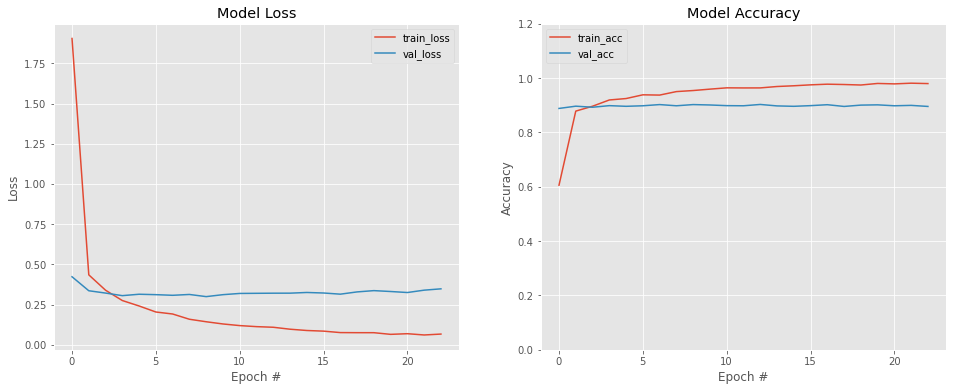


Starting fold 2

Training...
Evaluating model ...
256/256 [==============================] - 0s 2ms/step - loss: 0.1438 - accuracy: 0.9565


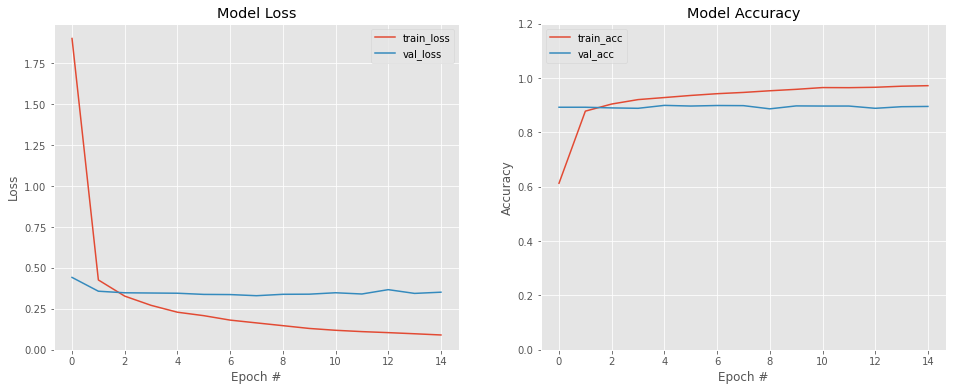


Starting fold 3

Training...
Evaluating model ...
256/256 [==============================] - 0s 2ms/step - loss: 0.0392 - accuracy: 0.9911


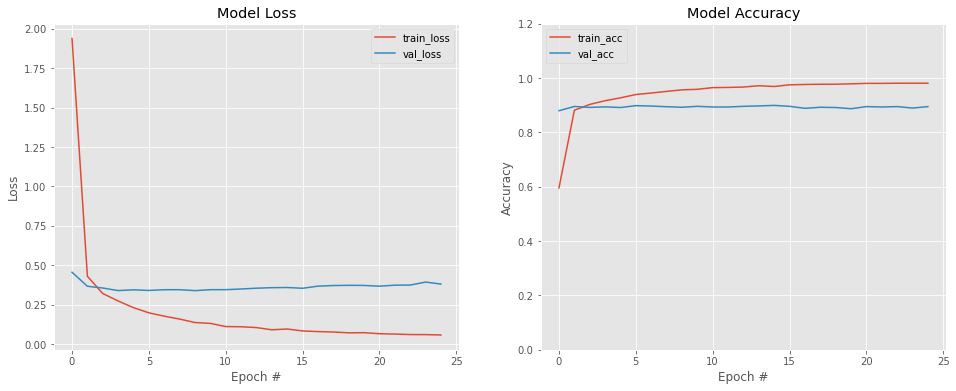


Starting fold 4

Training...
Evaluating model ...
256/256 [==============================] - 0s 2ms/step - loss: 0.0999 - accuracy: 0.9725


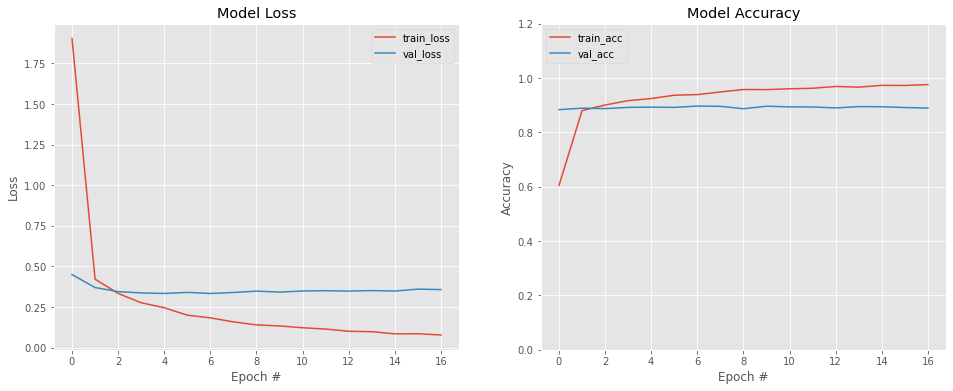


Starting fold 5

Training...
Evaluating model ...
256/256 [==============================] - 0s 2ms/step - loss: 0.0542 - accuracy: 0.9867


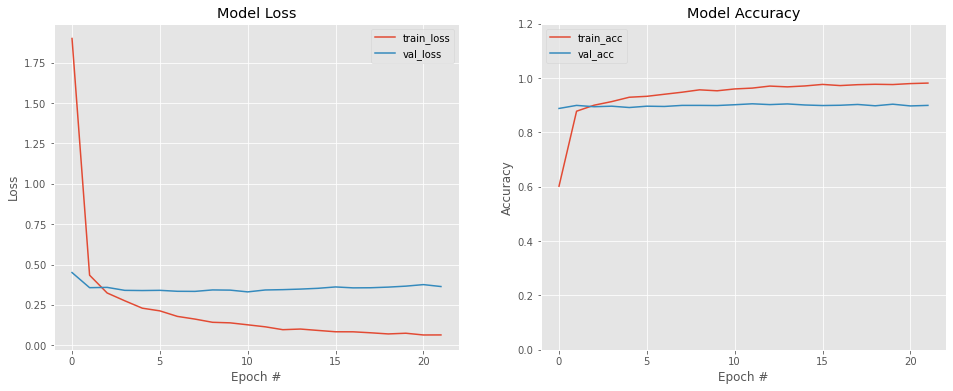


 CV Score -

TrainAccuracy - avg:0.9790155291557312, max:0.9910736083984375

TrainLoss - avg:0.07745523676276207, min:0.03916402533650398

ValAccuracy - avg:0.9006064534187317, max:0.9050880670547485

ValLoss - avg:0.34019723534584045, min:0.3207395374774933


In [24]:
from sklearn.model_selection import StratifiedKFold
# Use K fold of 5, to ensure train:validation is 80:20
splits = list(StratifiedKFold(n_splits=5, shuffle=True, random_state=10).split(final_train_features, Y))

trained_models = []
val_accuracy = []
val_losses = []
train_accuracy = []
train_losses = []

#Prepare And Train DNN model
for i, (train_idx, valid_idx) in enumerate(splits): 

    print(f"\nStarting fold {i+1}\n")
    x_train_fold = final_train_features[train_idx, :]
    y_train_fold = Yarr_hot[train_idx, :]
    x_val_fold = final_train_features[valid_idx]
    y_val_fold = Yarr_hot[valid_idx, :]

    dnn = keras.models.Sequential([
        InputLayer(final_train_features.shape[1:]),
        Dropout(0.7),
        Dense(120, activation='softmax')
    ])

    dnn.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    print("Training...")
    #Train simple DNN on extracted features.
    h = dnn.fit(x_train_fold, y_train_fold,
                batch_size=batch_size,
                epochs=epochs,
                verbose=0,
                validation_data = (x_val_fold, y_val_fold),
                callbacks=my_callback)
    print("Evaluating model ...")
    model_res_val = dnn.evaluate(x_val_fold, y_val_fold)
    model_res_train = dnn.evaluate(x_train_fold, y_train_fold)
    train_accuracy.append(model_res_train[1])
    train_losses.append(model_res_train[0])
    val_accuracy.append(model_res_val[1])
    val_losses.append(model_res_val[0])
    trained_models.append(dnn)
    plot_model_history(h, saving_name=f"fold_{i+1}_LA")
    

print('\n CV Score -')
print(f"\nTrainAccuracy - avg:{sum(train_accuracy)/len(train_accuracy)}, max:{max(train_accuracy)}")
print(f"\nTrainLoss - avg:{sum(train_losses)/len(train_losses)}, min:{min(train_losses)}")
print(f"\nValAccuracy - avg:{sum(val_accuracy)/len(val_accuracy)}, max:{max(val_accuracy)}")
print(f"\nValLoss - avg:{sum(val_losses)/len(val_losses)}, min:{min(val_losses)}")


In [75]:
from sklearn.model_selection import StratifiedKFold
# model combinations to train
options = [
    [0,1,2],[0,1,3],[0,1,4],[0,2,3],[0,2,4],
    [0,3,4],[1,2,3],[1,2,4],[1,3,4],[2,3,4],
]
# output cols
cols = [
    "option", "models",
    "ta_avg", "ta_max",
    "tl_avg", "tl_min",
    "va_avg", "va_max",
    "vl_avg", "vl_min", 
]

temp = pd.DataFrame(columns=cols)
for option in options:
    train_models = [model_names[i] for i in option]
    final_train_features = get_concat_features(train_models, feats_dict)

    gc.collect()
    nparray_info("Final feature maps", final_train_features)
    
    # Use K fold of 5, to ensure train:validation is 80:20
    splits = list(StratifiedKFold(n_splits=5, shuffle=True, random_state=10).split(final_train_features, Y))

    trained_models = []
    val_accuracy = []
    val_losses = []
    train_accuracy = []
    train_losses = []

    #Prepare And Train DNN model
    for i, (train_idx, valid_idx) in enumerate(splits): 

        print(f"\nStarting fold {i+1}\n")
        x_train_fold = final_train_features[train_idx, :]
        y_train_fold = Yarr_hot[train_idx, :]
        x_val_fold = final_train_features[valid_idx]
        y_val_fold = Yarr_hot[valid_idx, :]

        dnn = keras.models.Sequential([
            InputLayer(final_train_features.shape[1:]),
            Dropout(0.7),
            Dense(120, activation='softmax')
        ])

        dnn.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

        print("Training...")
        #Train simple DNN on extracted features.
        h = dnn.fit(x_train_fold, y_train_fold,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_data = (x_val_fold, y_val_fold),
                    callbacks=my_callback)
        print("Evaluating model ...")
        model_res_val = dnn.evaluate(x_val_fold, y_val_fold)
        model_res_train = dnn.evaluate(x_train_fold, y_train_fold)
        train_accuracy.append(model_res_train[1])
        train_losses.append(model_res_train[0])
        val_accuracy.append(model_res_val[1])
        val_losses.append(model_res_val[0])
        trained_models.append(dnn)

    print('\n CV Score -')
    print(f"\nTrainAccuracy - avg:{sum(train_accuracy)/len(train_accuracy)}, max:{max(train_accuracy)}")
    print(f"\nTrainLoss - avg:{sum(train_losses)/len(train_losses)}, min:{min(train_losses)}")
    print(f"\nValAccuracy - avg:{sum(val_accuracy)/len(val_accuracy)}, max:{max(val_accuracy)}")
    print(f"\nValLoss - avg:{sum(val_losses)/len(val_losses)}, min:{min(val_losses)}")
    result = np.array([option, train_models,
        sum(train_accuracy)/len(train_accuracy),
        max(train_accuracy),
        sum(train_losses)/len(train_losses),
        min(train_losses),
        sum(val_accuracy)/len(val_accuracy),
        max(val_accuracy),
        sum(val_losses)/len(val_losses),
        min(val_losses)
    ])
    temp=temp.append(pd.DataFrame(result.reshape(1,-1), columns=list(temp)),  ignore_index=True)
    temp.to_csv("output.csv")
print("ended")

collect features for Xception...
collect features for DenseNet169...
collect features for InceptionResNetV2...
Final feature maps
-  shape	 (10222, 5248)
-  dtype	 float32
- nbytes	 214580224 (204.64 MB)

Starting fold 1

Training...
Evaluating model ...
256/256 [==============================] - 0s 2ms/step - loss: 0.0867 - accuracy: 0.9779

Starting fold 2

Training...
Evaluating model ...
256/256 [==============================] - 0s 2ms/step - loss: 0.0457 - accuracy: 0.9891

Starting fold 3

Training...
Evaluating model ...
256/256 [==============================] - 0s 2ms/step - loss: 0.0853 - accuracy: 0.9762

Starting fold 4

Training...
Evaluating model ...
256/256 [==============================] - 0s 2ms/step - loss: 0.0362 - accuracy: 0.9918

Starting fold 5

Training...
Evaluating model ...
256/256 [==============================] - 0s 2ms/step - loss: 0.1961 - accuracy: 0.9436

 CV Score -

TrainAccuracy - avg:0.9757145285606384, max:0.9918072819709778

TrainLoss - avg:0.

In [76]:
temp.head(20)

,option,models,ta_avg,ta_max,tl_avg,tl_min,va_avg,va_max,vl_avg,vl_min
0,"[0, 1, 2]","[Xception, DenseNet169, InceptionResNetV2]",0.975715,0.991807,0.089984,0.036159,0.900411,0.905088,0.339074,0.309374
1,"[0, 1, 3]","[Xception, DenseNet169, MobileNet]",0.991318,0.999878,0.048805,0.009903,0.878693,0.883562,0.412478,0.382004
2,"[0, 1, 4]","[Xception, DenseNet169, InceptionV3]",0.984324,0.997188,0.064394,0.0254,0.893172,0.898239,0.359784,0.345557
3,"[0, 2, 3]","[Xception, InceptionResNetV2, MobileNet]",0.981095,0.998532,0.073631,0.018863,0.900411,0.903131,0.343664,0.333339
4,"[0, 2, 4]","[Xception, InceptionResNetV2, InceptionV3]",0.965343,0.98606,0.122201,0.050251,0.906769,0.909535,0.316728,0.295145
5,"[0, 3, 4]","[Xception, MobileNet, InceptionV3]",0.998484,0.999022,0.017853,0.014685,0.89366,0.896333,0.373783,0.347913
6,"[1, 2, 3]","[DenseNet169, InceptionResNetV2, MobileNet]",0.974663,0.985202,0.09118,0.059283,0.889453,0.897799,0.378946,0.36506
7,"[1, 2, 4]","[DenseNet169, InceptionResNetV2, InceptionV3]",0.975127,0.993886,0.086354,0.030393,0.904226,0.909535,0.340512,0.309464
8,"[1, 3, 4]","[DenseNet169, MobileNet, InceptionV3]",0.993788,0.998288,0.036335,0.014573,0.874584,0.879707,0.429489,0.414254
9,"[2, 3, 4]","[InceptionResNetV2, MobileNet, InceptionV3]",0.987894,0.998899,0.050326,0.012185,0.900899,0.905623,0.342619,0.318733


In [20]:
# # TEST IMAGES
# test_images_list = sorted(os.listdir(os.path.join(data_dir, 'test')))
# X = []
# i = 0
# for image in tqdm.tqdm(test_images_list):

#     image_path = os.path.join(data_dir, 'test',image)
#     orig_image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
#     res_image = cv2.resize(orig_image,(img_size, img_size))
#     X.append(res_image)
#     i+=1

# Xtesarr = np.array(X)

# del(X)
# gc.collect()

# Xtesarr.shape

In [21]:
# # FEATURE EXTRACTION OF TEST IMAGES
# test_features = get_concat_features(get_valfeatures, models, preprocs, Xtesarr)

# del(Xtesarr)
# gc.collect()
# print('Final feature maps shape', test_features.shape)

In [22]:
# y_pred_norm = trained_models[0].predict(test_features, batch_size=128)/3
# for dnn in trained_models[1:]:
#     y_pred_norm += dnn.predict(test_features, batch_size=128)/3

# y_pred_norm.shape

# df.iloc[:, 1:] = y_pred_norm
# df.to_csv('submission.csv')
